# Вводная

Для тестовых целей возьмем MovieLens-100k и будем считать, что рейтинги нам неизвестны - т.е., превратим его в implicit feedback-датасет.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

%matplotlib inline

In [2]:
MOVIELENS_PATH = '/home/anglerfish/mlens/dataset/ml-100k'

def read_implicit_mlens_data(file_name):
    df = pd.read_csv(
        os.path.join(MOVIELENS_PATH, file_name), sep='\t',
        names=['user', 'item', 'rating', 'timestamp'], header=None
    )
    df = df[['user', 'item']]
    # users and items are enumerated from 1, shift that to 0 
    df['user'] -= 1
    df['item'] -= 1
    return df

df_train = read_implicit_mlens_data('u1.base')
df_test = read_implicit_mlens_data('u1.test')


Сделаем baseline-модель, которая будет рекомендовать по популярности.

In [3]:
from sklearn.base import BaseEstimator as BaseSklearnEstimator


class BaseEstimator(BaseSklearnEstimator):
    
    def __init__(self, n_users, n_items):
        self.n_users = n_users
        self.n_items = n_items
        
    def fit(self, df):
        raise NotImplementedError
        
    def predict(self, users, n):
        # predicts top-n recommendations for each user from df
        raise NotImplementedError
        
    def score(self, df):
        # for each pair of (user, item) from df
        # outputs a score
        raise NotImplementedError
        
    def filter_by_already_owned_items(self, recommendations, owned_items):
        # preventing the recommender from recommending items
        # user already owns
        idx = np.in1d(recommendations['item'], owned_items['item'])
        return recommendations[~idx]
    
    def get_sparse_matrix(self, df):
        return sparse.csr_matrix(
            (np.ones(len(df)), (np.int32(df['user']), np.int32(df['item']))),
            shape=(self.n_users, self.n_items)
        )
    
    

def bincount_relative(arr, length):
    assert np.max(arr) < length, 'Required length should be greater than max(arr)+1'
    counts = np.bincount(arr, minlength=length).astype(np.float32)
    counts /= counts.sum()
    return counts
           

class Popular(BaseEstimator):
    
    def fit(self, df):
        self._owned_items = df.copy()
        
        items, counts = np.unique(df['item'], return_counts=True)
        idx = np.argsort(counts)[::-1]
        popularity = counts / float(counts.sum())
        
        # store popularity scores sorted from top to bottom for top-n recommendations
        self._top_items = items[idx]
        self._top_scores = popularity[idx]
        
        # also store popularity scores sorted by item order for score lookups
        idx = np.argsort(items)
        self._popularity = bincount_relative(df['item'].values, self.n_items)
        
        return self
        
    def predict(self, users, n):
        result = []
        
        owned_item_dict = {
            user: user_items for user, user_items in
            self._owned_items[self._owned_items['user'].isin(users)].groupby('user')
        }
        
        for user in users:
            user_items = owned_item_dict.get(user, [])
            # cannot filter out more then len(user_items) recommendations
            # therefore we need n + len(user_items) candidates
            n_candidates = n + len(user_items)
            
            user_recommendations = pd.DataFrame(dict(
                user=np.repeat(user, n_candidates),
                item=self._top_items[:n_candidates],
                value=self._top_scores[:n_candidates]
            ))
            if len(user_items) > 0:
                user_recommendations = self.filter_by_already_owned_items(
                    user_recommendations, user_items
                ).iloc[:n]
            result.append(user_recommendations)
        
        return pd.concat(result)
            
    def score(self, df):
        result = df.copy()
        result['value'] = self._popularity[result['item']]
        return result

In [4]:
n_users = 943
n_items = 1682

model = Popular(n_users, n_items)
model.fit(df_train)

Popular(n_items=1682, n_users=943)

In [5]:
model.predict(df_test['user'].unique()[:2], n=5).head(10)

,item,user,value
2,257,0,0.005025
3,99,0,0.004938
4,293,0,0.004925
5,287,0,0.004888
6,285,0,0.004850
0,49,1,0.006050
1,180,1,0.005275
8,120,1,0.004412
10,173,1,0.004300
12,55,1,0.003900


Теперь добавим немного метрик, чтобы посчитать успешность порекомендованного. Ограничимся пока чем-нибудь несложным типа precision@k, усредненным по юзерам.

In [16]:
def precision_score_at_k(df_test, df_predict, k):
    df_test_dict = {user: user_items for user, user_items in df_test.groupby('user')}
    scores = []
    for user, recommendations in df_predict.groupby('user'):
        user_items = df_test_dict.get(user, [])
        if len(user_items) == 0:
            continue
        intersection = np.intersect1d(user_items['item'], recommendations['item'].iloc[:k])
        n_matches = float(len(intersection))
        scores.append(n_matches / min(k, len(user_items)))
    if not scores:
        raise Exception("Users from test and train set don't intersect!")
    else:
        return np.mean(scores)


In [113]:
df_predict = model.predict(df_test['user'].unique(), n=5)
precision_score_at_k(df_test, df_predict, k=5)

0.32389251997095136

Добавим второй baseline: классических item-item ближайших соседей.

In [116]:
from scipy import sparse
from sklearn.neighbors import NearestNeighbors


class ItemItem(BaseEstimator):
    
    def __init__(self, n_users, n_items, k=50, metric='cosine'):
        super(ItemItem, self).__init__(n_users, n_items)
        self.k = k
        self.metric = metric
        
    def neighbors_to_similarity(self, distances, indices):
        row_idx = np.repeat(np.arange(self.n_items), self.k)
        col_idx = indices.ravel(order='C')
        value = (1 - distances).ravel(order='C')

        # add diagonal entries
        row_idx = np.hstack([row_idx, np.arange(self.n_items)])
        col_idx = np.hstack([col_idx, np.arange(self.n_items)])
        value = np.hstack([value, np.ones(self.n_items)])
        
        return sparse.csr_matrix(
            (value, (row_idx, col_idx)), shape=(self.n_items, self.n_items), dtype=np.float32
        )
        
    def fit(self, df):
        self._owned_items = df.copy()
        
        interaction_matrix = self.get_sparse_matrix(df)  # it's users x items by default, so transpose it
        knn = NearestNeighbors(n_neighbors=self.k, algorithm='brute', metric=self.metric).fit(interaction_matrix.T)
        distances, indices = knn.kneighbors()
        
        # reconstruct similarity matrix from neighbors
        similarity = self.neighbors_to_similarity(distances, indices)
        
        self._predictions = interaction_matrix.dot(similarity)
        return self
    
    def predict(self, users, n):
        result = []
        item_ids = np.arange(self.n_items)
        owned_item_dict = {
            user: user_items for user, user_items in
            self._owned_items[self._owned_items['user'].isin(users)].groupby('user')
        }
        
        for user in users:
            user_items = owned_item_dict.get(user, [])
            n_candidates = n + len(user_items)
            
            scores = self._predictions[user, :].toarray().ravel()
            idx = np.argpartition(-scores, n_candidates)[:n_candidates]
            
            user_recommendations = pd.DataFrame(dict(
                user=np.repeat(user, n_candidates),
                item=item_ids[idx],
                value=scores[idx]
            ))
            if len(user_items) > 0:
                user_recommendations = self.filter_by_already_owned_items(
                    user_recommendations, user_items
                ).iloc[:n]
                
            # argpartition doesn't sort top-n values, so let's not forget to do it here
            result.append(user_recommendations.sort_values(by=['value']))

        return pd.concat(result)
    
    def score(self, df):
        return self._predictions[df['user'], df['item']]
        
        

In [117]:
model = ItemItem(n_users, n_items, k=5)
model.fit(df_train)
df_predict = model.predict(df_test['user'].unique(), n=5)
precision_score_at_k(df_test, df_predict, k=5)

0.42309368191721142

Попробуем модель на основе BPR. Чтобы не писать все самому, можно пока воспользоваться готовыми решениями - для Питона, например, есть lightfm.

In [124]:
from lightfm import LightFM


class LightfmBPR(BaseEstimator):
    
    def __init__(self, n_users, n_items, params=None, n_epochs=30):
        super(LightfmBPR, self).__init__(n_users, n_items)
        self.params = params or {}
        self.n_epochs = n_epochs
        
    def fit(self, df):
        self._owned_items = df.copy()

        # convert data to sparse matrix
        matrix = sparse.csr_matrix(
            (np.ones(len(df)), (np.int32(df['user']), np.int32(df['item']))),
            shape=(self.n_users, self.n_items)
        )
        
        self._lightfm = LightFM(**self.params)
        self._lightfm.fit(matrix, epochs=self.n_epochs, num_threads=4)
        
        return self
        
    def predict(self, users, n):
        result = []
        item_ids = np.arange(self.n_items)
        owned_item_dict = {
            user: user_items for user, user_items in
            self._owned_items[self._owned_items['user'].isin(users)].groupby('user')
        }
        for user in users:
            user_items = owned_item_dict.get(user, [])
            n_candidates = n + len(user_items)
            
            scores = self._lightfm.predict(user, item_ids)
            idx = np.argpartition(-scores, n_candidates)[:n_candidates]
            
            user_recommendations = pd.DataFrame(dict(
                user=np.repeat(user, n_candidates),
                item=item_ids[idx],
                value=scores[idx]
            ))
            if len(user_items) > 0:
                user_recommendations = self.filter_by_already_owned_items(
                    user_recommendations, user_items
                ).iloc[:n]
                
            # argpartition doesn't sort top-n values, so let's not forget to do it here
            result.append(user_recommendations.sort_values(by=['value']))
        
        return pd.concat(result)
        
        
    def score(self, df):
        result = df.copy()
        result['value'] = self._lightfm.predict(df['user'], df['item'])
        return result

In [125]:
model = LightfmBPR(n_users, n_items, params={'loss': 'bpr'})
model.fit(df_train)
df_predict = model.predict(df_test['user'].unique(), n=5)
precision_score_at_k(df_test, df_predict, k=5)

0.34662309368191724

Частично проблему видно уже здесь, даже при том, что мы не трогали параметры модели, число латентных факторов и т.д. - результат значительно хуже, чем у ItemItem (и сравним с популярным бейзлайном). Но если включить более умный сэмплер (warp), все сразу становится лучше:

In [126]:
model = LightfmBPR(n_users, n_items, params={'loss': 'warp'})
model.fit(df_train)
df_predict = model.predict(df_test['user'].unique(), n=5)
precision_score_at_k(df_test, df_predict, k=5)

0.42883079157588966

# Датасет с мобильными приложениям

Попробуем сделать то же самое с нашим искомым датасетом: для демонстрации я пока взял только небольшой кусок. В отличие от mlens, он не побит сразу на train и test, и нам это надо для начала сделать. Тактика такая: сначала выбираем N тестовых юзеров, потом разделяем их айтемы на train и test части. В случае с mlens мы гоняли тесты на всех юзерах сразу, потому что их было немного, но в новом датасете их ~500k, поэтому придется выбирать подмножество. Для разбивки можно пользоваться вот такой тулзой по образу и подобию sklearn cross-validation:

In [20]:
class UserBasedShuffleSplit(object):
    """
    Cross-validation for recommenders splits test and train sets
    across items of the same users: i.e., if item I of user U is
    present in a test set, user U (with some other items) must
    also be present in the corresponding train set.
    """

    def __init__(self, array, test_user_size=0.1, test_item_size=1, n_splits=1):
        assert isinstance(test_user_size, (int, float)), 'test_user_size must be int or float'
        assert isinstance(test_item_size, int), 'test_user_size must be integer'

        self.array = array[['user', 'item']].copy()
        self.array['index'] = np.arange(len(self.array))
        self.test_user_size = test_user_size
        self.test_item_size = test_item_size
        self.n_splits = n_splits

    def get_splittable_users(self):
        """
        Returns all suitable users (those who have sufficient
        amount of items).
        """
        users, counts = np.unique(self.array['user'], return_counts=True)
        return users[counts > self.test_item_size]

    def get_subset_to_split(self, splittable_users):
        """
        Returns a subset of original `array` which contains users
        with sufficient amount of items to split into two sets.
        """
        if isinstance(self.test_user_size, float):
            test_user_size = int(self.test_user_size * len(splittable_users))
        else:
            test_user_size = self.test_user_size
        return self.array[np.in1d(
            self.array['user'],
            np.random.choice(splittable_users, test_user_size, replace=False)
        )]

    def __len__(self):
        return self.n_splits

    def __iter__(self):
        self.splittable_users = self.get_splittable_users()
        for _ in xrange(self.n_splits):
            splittable_subset = self.get_subset_to_split(self.splittable_users)
            test_idx = []
            for user, subset in splittable_subset.groupby('user'):
                test_idx.append(self.split_user(subset))

            test_idx = np.hstack(test_idx)
            train_idx = np.setdiff1d(np.arange(len(self.array)), test_idx)
            yield train_idx, test_idx

    def split_user(self, subset):
        return np.random.choice(subset['index'], self.test_item_size, replace=False)

In [21]:
LAUNCHER_SAMPLE_PATH = '/home/anglerfish/launcher_sample.csv'

launcher = pd.read_csv(LAUNCHER_SAMPLE_PATH)
launcher.head()

,user,item
0,12156,5527
1,7982,15525
2,5614,13600
3,465,14937
4,465,9556


In [22]:
cv = UserBasedShuffleSplit(launcher, test_user_size=1000, test_item_size=10)
train_idx, test_idx = next(iter(cv))

df_train = launcher.iloc[train_idx]
df_test = launcher.iloc[test_idx]

In [23]:
n_users = launcher['user'].nunique()
n_items = launcher['item'].nunique()

model = Popular(n_users, n_items)
model.fit(df_train)
df_predict = model.predict(df_test['user'].unique(), n=5)
precision_score_at_k(df_test, df_predict, k=5)

0.086800000000000016

In [143]:
model = ItemItem(n_users, n_items)
model.fit(df_train)
df_predict = model.predict(df_test['user'].unique(), n=5)
precision_score_at_k(df_test, df_predict, k=5)

0.14360000000000003

In [144]:
model = LightfmBPR(n_users, n_items, params={'loss': 'bpr'})
model.fit(df_train)
df_predict = model.predict(df_test['user'].unique(), n=5)
precision_score_at_k(df_test, df_predict, k=5)

0.065600000000000006

In [145]:
model = LightfmBPR(n_users, n_items, params={'loss': 'warp'})
model.fit(df_train)
df_predict = model.predict(df_test['user'].unique(), n=5)
precision_score_at_k(df_test, df_predict, k=5)

0.10280000000000002

Видимо, что все плохо: BPR работает хуже, чем популярный бейзлайн, хотя warp-семплер все еще сильно ему помогает. Но ItemItem по-прежнему тащит лучше всех, и это не радует. Предполагаемая причина заключается вот в этом:

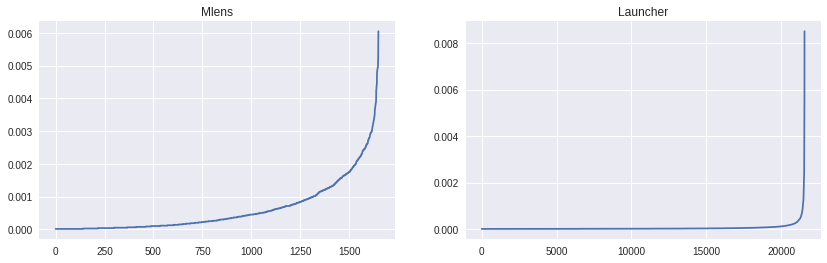

In [152]:
plt.figure(figsize=(14, 4))

for i, (df, title) in enumerate([
    (read_implicit_mlens_data('u1.base'), 'Mlens'),
    (df_train, 'Launcher')
], start=1):
    plt.subplot(1, 2, i)
    plt.title(title)
    _, counts = np.unique(df['item'], return_counts=True)
    counts.sort()
    counts = counts / float(counts.sum())
    plt.plot(counts)
plt.show()

Распределение айтемов в лончерном датасете намного более сильно скошено в сторону головы, что согласуется с наблюдениями в статье Рендла.

# Пишем свой BPR

Чтобы экспериментировать с сэмплерами, нам понадобится своя модель. Я содрал реализацию [отсюда](https://github.com/bbc/theano-bpr), но поскольку Theano уже не очень живой, переделал ее на Tensorflow.

Напишем сначала классы для сэмплеров. Сэмплер должен принимать на вход df, а выдавать аналогичный датафрейм с колонками user и item, где айтемы будут подбираться из числа implicit negatives - т.е., выходных сочетаний user-item **не** должно быть в оригинальном фрейме.

В текущем простом виде это означает следующее: нам нужно взять юзера, засэмплить для него какой-то количество айтемов, а потом проверить, что таких у него еще нет. Если получим случайное совпадение - повторять до тех пор, пока их не останется. Такую наиванильнейшую реализацию сэмплинга можно подсмотреть в том же [theano-bpr](https://github.com/bbc/theano-bpr/blob/master/theano_bpr/bpr.py#L180). Она очень читабельная, но у нее есть фатальный недостаток - она еще и очень медленная. np.random.choice работает сильно лучше в векторизованом виде, поэтому можно немного пожертвовать читабельностью и сэмплить айтемы сразу для всех юзеров, а потом в цикле искать совпадения. Реализация приведена ниже:

In [9]:
import pandas as pd

class Sampler(object):
    
    def __init__(self, df, n_items, factor=1, max_attempts=100):
        self.df = df
        self.n_items = n_items
        self.factor = factor
        self.max_attempts = max_attempts
        
        
class StaticSampler(Sampler):
            
    def sample(self):
        n_samples = len(self.df) * self.factor
        
        # make a user-by-items dictionary
        data_dict = {}
        for user, user_items in self.df.groupby('user'):
            data_dict[user] = set(user_items['item'])

        sampled_users = np.repeat(self.df['user'].values, self.factor)
        left_out_users = np.arange(n_samples)
        sampled_negative_items = np.zeros(n_samples)
    
        weights = self.get_distribution()

        # sample negative items by sampling all items at once
        # and then retrying for items that are in `data_dict`
        attempts = 0
        while len(left_out_users) > 0 and attempts < self.max_attempts:
            failed = []
            neg_items = np.random.choice(self.n_items, p=weights, size=len(left_out_users))
            for item_idx, user_idx in enumerate(left_out_users):
                user = sampled_users[user_idx]
                item = neg_items[item_idx]
                if item in data_dict[user]:
                    failed.append(user_idx)
                else:
                    sampled_negative_items[user_idx] = item
            if len(left_out_users) == len(failed):
                attempts += 1
            left_out_users = failed
            
        if len(left_out_users) != 0:
            raise ValueError(
                "Couldn't sample enough implicit negatives: {} users left out".format(
                    len(left_out_users)
                )
            )

        return pd.DataFrame(dict(
            user=sampled_users,
            item=np.int32(sampled_negative_items)
        ))
        
            
class UniformSampler(StaticSampler):
    
    def get_distribution(self):
        return np.ones(self.n_items) / float(self.n_items)
    
    
class EmpiricalSampler(StaticSampler):
    
    def get_distribution(self):
        # weight items according to popularity
        return bincount_relative(self.df['item'], self.n_items)
        

In [185]:
s = EmpiricalSampler(df_train, n_items)
negatives = s.sample()
positive_pairs = set(zip(df_train['user'], df_train['item']))
negative_pairs = set(zip(negatives['user'], negatives['item']))

assert len(positive_pairs.intersection(negative_pairs)) == 0

Дальше сделаем сам класс.

In [14]:
import tensorflow as tf

class BPR(BaseEstimator):
    
    def __init__(self, n_users, n_items, sampler_class,
                 user_regularization=0.0025,
                 positive_item_regularization=0.0025,
                 negative_item_regularization=0.00025,
                 bias_regularization=0.0,
                 learning_rate=0.01,
                 n_features=50,
                 batch_size=1000,
                 n_epochs=20):
        super(BPR, self).__init__(n_users, n_items)
        self.sampler_class = sampler_class
        self.user_regularization = user_regularization
        self.positive_item_regularization = positive_item_regularization
        self.negative_item_regularization = negative_item_regularization
        self.bias_regularization = bias_regularization
        self.learning_rate = learning_rate
        self.n_features = n_features
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        
        self.user_idx = tf.placeholder(tf.int32, [None])
        self.positive_item_idx = tf.placeholder(tf.int32, [None])
        self.negative_item_idx = tf.placeholder(tf.int32, [None])
        self.build_graph()
        
    def build_graph(self):
        self.user_emeddings = tf.Variable(
            tf.random_normal([self.n_users, self.n_features], mean=0.0, stddev=0.1)
        )
        self.item_embeddings = tf.Variable(
            tf.random_normal([self.n_items, self.n_features], mean=0.0, stddev=0.1)
        )
        self.item_biases = tf.Variable(
            tf.zeros([self.n_items])
        )

        users = tf.nn.embedding_lookup(
            self.user_emeddings, self.user_idx
        )
        positive_items = tf.nn.embedding_lookup(
            self.item_embeddings, self.positive_item_idx
        )
        positive_item_bias = tf.nn.embedding_lookup(
            self.item_biases, self.positive_item_idx
        )
        negative_items = tf.nn.embedding_lookup(
            self.item_embeddings, self.negative_item_idx
        )
        negative_item_bias = tf.nn.embedding_lookup(
            self.item_biases, self.negative_item_idx
        )
        
        positive_interactions = tf.diag_part(tf.matmul(
            users, tf.transpose(positive_items)
        )) + positive_item_bias
        negative_interactions = tf.diag_part(tf.matmul(
            users, tf.transpose(negative_items)
        )) + negative_item_bias
        objective = tf.reduce_sum(
            tf.log(tf.nn.sigmoid(
                positive_interactions - negative_interactions
            )) -
            self.user_regularization * tf.reduce_sum(tf.pow(users, 2), axis=1) - 
            self.positive_item_regularization * tf.reduce_sum(tf.pow(positive_items, 2), axis=1) -
            self.negative_item_regularization * tf.reduce_sum(tf.pow(negative_items, 2), axis=1) -
            self.bias_regularization * (
                tf.pow(positive_item_bias, 2) +
                tf.pow(negative_item_bias, 2)
            )
        )
        self.cost = -objective
        self.train = tf.train.AdamOptimizer(self.learning_rate).minimize(
            self.cost,
            var_list=[self.user_emeddings, self.item_embeddings, self.item_biases]
        )
        self.prediction = positive_interactions
        
    def fit(self, df):
        self._owned_items = df.copy()
        
        init = tf.global_variables_initializer()
        session = tf.InteractiveSession()
        session.run(init)
        
        sampler = self.sampler_class(df, self.n_items)
        df_negative = sampler.sample()
        
        for epoch in range(self.n_epochs):
            costs = []
            for batch_idx in xrange(0, len(df) - self.batch_size, self.batch_size):
                positive_batch = df[batch_idx: batch_idx + self.batch_size]
                negative_batch = df_negative[batch_idx: batch_idx + self.batch_size]
                params = {
                    self.user_idx: np.int32(positive_batch['user']),
                    self.positive_item_idx: np.int32(positive_batch['item']),
                    self.negative_item_idx: np.int32(negative_batch['item'])
                }
                _, cost = session.run([self.train, self.cost], params)
                costs.append(cost / self.batch_size)
            print 'epoch', epoch, 'train loss', np.mean(costs)
    
    def predict(self, users, n):
        result = []
        item_ids = np.arange(self.n_items)
        owned_item_dict = {
            user: user_items for user, user_items in
            self._owned_items[self._owned_items['user'].isin(users)].groupby('user')
        }
        
        users = np.int32(users)
        user_embeddings = self.user_emeddings.eval()[users, :]
        item_embeddings = self.item_embeddings.eval().T
        item_biases = self.item_biases.eval()
        
        for i, user in enumerate(users):
            user_items = owned_item_dict.get(user, [])
            n_candidates = n + len(user_items)
            
            scores = (
                user_embeddings[i].reshape(1, self.n_features).dot(item_embeddings) +
                item_biases
            ).ravel()
            idx = np.argpartition(-scores, n_candidates)[:n_candidates]
            
            user_recommendations = pd.DataFrame(dict(
                user=np.repeat(user, n_candidates),
                item=item_ids[idx],
                value=scores[idx]
            ))
            if len(user_items) > 0:
                user_recommendations = self.filter_by_already_owned_items(
                    user_recommendations, user_items
                ).iloc[:n]
                
            result.append(user_recommendations.sort_values(by=['value']))
        
        return pd.concat(result)

In [24]:
model = BPR(n_users, n_items, sampler_class=UniformSampler)
model.fit(df_train)
df_predict = model.predict(df_test['user'].unique(), n=5)
precision_score_at_k(df_test, df_predict, k=5)

epoch 0 train loss 0.420092424547
epoch 1 train loss 0.159423685479
epoch 2 train loss 0.0609791634828
epoch 3 train loss 0.0469853703709
epoch 4 train loss 0.0439875918355
epoch 5 train loss 0.0425525149194
epoch 6 train loss 0.0415514389465
epoch 7 train loss 0.0408371816215
epoch 8 train loss 0.040330353203
epoch 9 train loss 0.0399652271418
epoch 10 train loss 0.0397044016348
epoch 11 train loss 0.0395352795354
epoch 12 train loss 0.0397939762498
epoch 13 train loss 0.0407404784714
epoch 14 train loss 0.0422387396765
epoch 15 train loss 0.0426373509882
epoch 16 train loss 0.041459986278
epoch 17 train loss 0.0398295369388
epoch 18 train loss 0.0388730050312
epoch 19 train loss 0.0385923461914


0.069000000000000006

In [26]:
uniform_sampler_predictions = df_predict.copy()

In [28]:
model = BPR(n_users, n_items, sampler_class=EmpiricalSampler)
model.fit(df_train)
empirical_sampler_predictions = model.predict(df_test['user'].unique(), n=5)
precision_score_at_k(df_test, empirical_sampler_predictions, k=5)

epoch 0 train loss 0.671308547443
epoch 1 train loss 0.332555174426
epoch 2 train loss 0.132005211598
epoch 3 train loss 0.0870138952925
epoch 4 train loss 0.0791039937583
epoch 5 train loss 0.0768154152903
epoch 6 train loss 0.0758402482036
epoch 7 train loss 0.0754455930349
epoch 8 train loss 0.0754046203068
epoch 9 train loss 0.0756912728019
epoch 10 train loss 0.0762085213606
epoch 11 train loss 0.0770736479373
epoch 12 train loss 0.0785167017462
epoch 13 train loss 0.0814809785791
epoch 14 train loss 0.0853597871199
epoch 15 train loss 0.0860325593691
epoch 16 train loss 0.0818899249957
epoch 17 train loss 0.0795738562359
epoch 18 train loss 0.0784014782998
epoch 19 train loss 0.0782131375346


0.0091999999999999998

Unform-сэмплер примерно воспроизвел то же, что и LightFM, а вот с empirical все совсем плохо, и метрика получается ужасная. Проверим теперь гипотезу о том, что uniform пытается быть похожим на popular baseline, а empirical - наоборот.

In [29]:
model = Popular(n_users, n_items)
model.fit(df_train)

Popular(n_items=21601, n_users=17583)

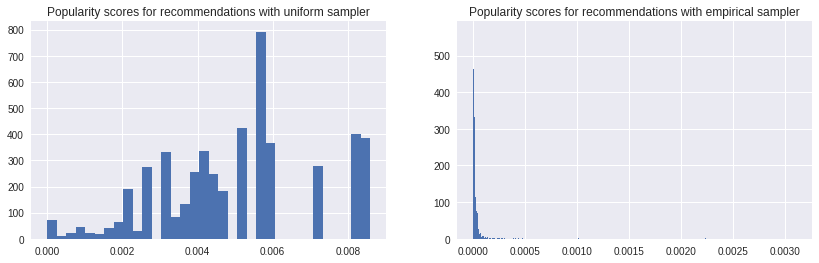

In [34]:
uniform_popularity = model.score(uniform_sampler_predictions)['value']
empirical_popularity = model.score(empirical_sampler_predictions)['value']

plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
plt.title('Popularity scores for recommendations with uniform sampler')
plt.hist(uniform_popularity, bins='auto')

plt.subplot(1, 2, 2)
plt.title('Popularity scores for recommendations with empirical sampler')
plt.hist(empirical_popularity, bins='auto')

plt.show()

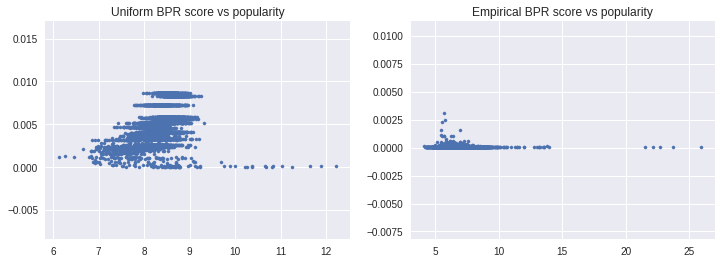

In [54]:
from scipy.stats import pearsonr

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title("Uniform BPR score vs popularity")

plt.scatter(
    uniform_sampler_predictions['value'],
    uniform_popularity, s=10
)

plt.subplot(1, 2, 2)
plt.title("Empirical BPR score vs popularity")

plt.scatter(
    empirical_sampler_predictions['value'],
    empirical_popularity, s=10
)

plt.show()

In [56]:
print 'Correlation with popularity:'
print 'uniform scores:', pearsonr(uniform_popularity, uniform_sampler_predictions['value'])[0]
print 'empirical scores:', pearsonr(empirical_popularity, empirical_sampler_predictions['value'])[0]

Correlation with popularity:
uniform scores: 0.446088
empirical scores: -0.042632
